# Lesson 11 - Vortex-source panel method


**Lesson09 Recap**: source-panel method to represent a circular cylinder 

**Lesson10 Recap**: Source-panel method to represent a symmetric airfoil

What if we want there to be lift? 
We need to keep in mind the **Kutta-condition** that allows us to determine wat the right amount of circulation there should be to generate lift

## A lifting-body panel method

If we calculated the flow from a free-stream and a source sheet only at an angle of nonzero, the rear stagnation point will not be located at the trailing edge. Instead, the stagnation point will be somewhere on the top surface of the airfoil. This is nont physically possible solution.

### The Kutta conditon

Stats that the pressure below and above the airfoil trailing edge must be equal so that the flow does not bend around it and instead leaves the airfoil tangentially. The rear stagnation point must be exactly at the trailing edge. This allows us to correct potential-flow theory so that it gives a solution closer to reality. 


**Lift always requires circulation**

### Discretization into panels 

Let's get the preliminaries out of the way. We need to import our favortie libraries!

In [1]:
# import libraries and modules needed 
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot 

# integrate plots into the notebook 
%matplotlib inline 

In [2]:
# load geometry from data file 
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile: 
    x,y = np.loadtxt(infile, dtype=float, unpack = True)

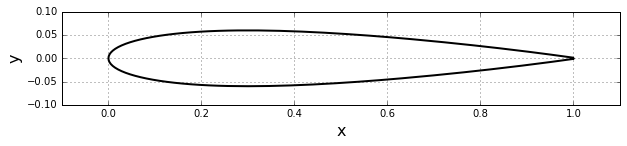

In [3]:
# plot the geometry
width =10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x,y,color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1,0.1);

In [4]:
class Panel: 
    """ 
    contains inforation related to a panel. 
    """
    def __init__(self,xa,ya,xb,yb):
        """
        Initialized the panel. 
        
        Sets the end-points and calculates the center-point, length, 
        and angle(with x-axis) of the panel. 
        Defines if the panel is located on the upper or lower surface of the geometry. 
        Initializes the source-strength, tangential velocity, and pressure coefficient 
        of the panel to zero. 
        
        Parameters
        ---------
        xa: float 
            x-coordinate of the first end-point.
        ya: float 
            y-coordinate of the first end-point. 
        xb: float 
            x-coordinate of the second end-point.
        yb: float 
            y-coordinate of the second end-point. 
        """
        
        self.xa, self.ya = xa, ya #panel starting-point 
        self.xb, self.yb = xb,yb # panel ending point 
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2) 
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0: 
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0: 
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        # panel location 
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt =0.0
        self.cp = 0.0 
    

In [5]:
def define_panels(x,y,N=40):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats 
        x-coordinates of defining geometry 
    y: 1D array of floats 
        y-coordinates of defining geometry
    N: integer, optional
        Number of panels (default: 40)
    
    
    Returns 
    -------
    panels: 1D numpy array of panel objects 
        list of the panels 
    """
    
    R = (x.max()-x.min())/2.0        # circle radius
    x_center = (x.max()+x.min())/2.0 # x-coordinate of circle center
    
    theta = np.linspace(0.0, 2.0*np.pi, N+1) # array of angles
    x_circle = x_center +  R*np.cos(theta)      # x-coordinates of circle
    
    x_ends = np.copy(x_circle)     # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends) # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels
    

In [6]:
#discretize geometry into panels 
panels = define_panels(x,y,N=40)

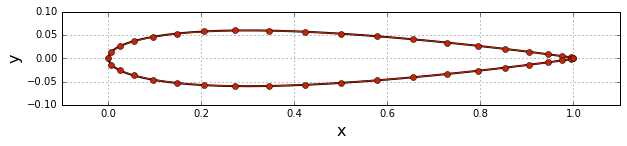

In [7]:
#plot the discretized geometry 
width= 10 
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x,y,color='k', linestyle = '-', linewidth=2)
pyplot.plot(np.append([panel.xa for panel in panels], panels[0].xa),
           np.append([panel.ya for panel in panels], panels[0].ya), 
           linestyle='-', linewidth=1, marker= 'o', markersize=6, color= '#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

### Free stream conditions 


In [8]:
class Freestream: 
    """
    Freestream conditions
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees). 
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0. 
        alpha: float, optional
            Angle of attack in degrees; 
            default= 0.0. 
        """
        self.u_inf = u_inf 
        self.alpha = alpha*np.pi/180.0 #degrees to radians 

In [9]:
# define freestream conditions 
freestream = Freestream(u_inf=1.0, alpha=4.0)

### Flow Tangency Boundary Condition

A constant vortex strength will be added to each panel (all panels have the same, constant vortex-sheet strength) and the flow normal to the panel is going to be zero. 


### Building a linear system 

[A][sigma, gamma] = [b]



In [10]:
def integral(x,y,panel,dxdk,dydk):
    """
    Evaluates the contribution from a panel at a given point. 
    
    Parameters
    ----------
    x: float 
        x-coordinate of the target point
    y: float 
        y-coordinate of the target point
    panel: Panel object 
        Panel whose contribution is evaluated
    dxdk: float 
        Value of the derivative of x in a certain direction. 
    dydk: float 
        Value of the derivative of y in a certain direction. 
        
    Returns
    -------
    Contribution from the panel at a given point (x,y). 
    """
    def integrand(s):
        return ( ((x -(panel.xa - np.sin(panel.beta)*s))*dxdk
                 +(y -(panel.ya + np.cos(panel.beta)*s))*dydk)
               / ((x - (panel.xa - np.sin(panel.beta)*s))**2 
                 + (y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

We first define the function **source_contribution_normal** to build the source matrix (the weight from each source on the normal velocity of each panel): 

In [11]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity. 
    
    Parameters
    ----------
    panels: 1D array of Panel objects 
        List of panels. 
    
    Returns
    -------
    A: 2D numpy array of floats
        Source contribution matrix
    """
    
    A = np.empty((panels.size, panels.size))
    # source contribution on a panel from itself 
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others 
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j: 
                A[i,j]= 0.5/np.pi*integral(panel_i.xc, panel_i.yc,
                                          panel_j, 
                                          np.cos(panel_i.beta),
                                          np.sin(panel_i.beta))
    return A

Then, we define **vortex_contribution_normal** to build the vortex matrix:

In [12]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity. 
    
    Parameters
    ----------
    panels: 1D array of panel objects 
        List of panels. 
        
    Returns 
    -------
    AL 2D Numpy array of floats 
        Vortex contribution matrix. 
    """
    A = np.empty((panels.size, panels.size))
    # vortex contribution on a panel from itself 
    np.fill_diagonal(A, 0.0)
    #vortex contribution on a panel from others 
    for i, panel_i in enumerate(panels): 
        for j, panel_j in enumerate(panels): 
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    
    return A

In [13]:
#let's call our functions and create our matrices

A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

We still have to apply the **Kutta Condition**

In [19]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta Condition array. 
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats 
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats 
        Vortex contribution matrix for normal velocity. 
    
    Returns
    -------
    b: 1D Numpy array of floats 
        The left-hand side of the Kutta-condition equation. 
    """
    
    b = np.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity 
    # is the same than matrix of vortex contribution on normal velocity 
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential vleocity is the opposite of 
    #matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [20]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system 
    arising from source and vortex contributions. 
    
    Parameters
    ----------
    A_source: 2D numpy array of floats 
        Source contribution matrix for the normal velocity.
    B_vortex: 2D numpy array of floats 
        Vortex contribution matrix for the normal velocity 
    
    Returns 
    --------
    A: 2D numpy array of floats 
        Matrix of the linear system. 
    """
    A = np.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype = float)
    # source contribution matrix 
    A[:-1, :-1] = A_source 
    #vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    #Kutta condition array 
    A[-1, :]= kutta_condition(A_source, B_vortex)
    return A

In [21]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right hand side of the system 
    arising from the freestream contribution. 
    
    Parameters
    ----------
    panels: 1D array of Panel objects 
        List of panels. 
    freestream: freestrea, object 
        Freestream conditions. 
        
    Returns 
    --------
    b: 1D numpy array of floats 
        Freestream contribution on each panel and on the kutta condition. 
    """
    b= np.empty(panels.size+1, dtype=float)
    # freestream contribution on each panel 
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf*np.cos(freestream.alpha-panel.beta)
    #freestream contribution  on the Kutta condition 
    b[-1]= -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                             + np.sin(freestream.alpha-panels[-1].beta) )
    return b

In [22]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

We are going to use the Scipy function **linalg.solve** and we can store the results of sigma (source) and gamma (vortex)

In [23]:
#solve for singularity strengths 
strengths = np.linalg.solve(A,b)

#store source strength on each panel 
for i, panel in enumerate(panels):
    panel.sigma = strengths[i]

#store circulation density 
gamma = strengths[-1]

## Surface Pressure Coefficient 

The pressure coefficient at the i-th panel center is our normal equation with the tangential velocity 

We are going to compute the tangential velocity at each panel center using the function **compute_tangential_velocity**:

In [28]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    computes the tangential surface velocity 
    
    Parameters
    ----------
    panels: 1D array of Panel objects 
        List of panels. 
    freestream: Freestream Object
        freestream conditions. 
    gamma: float
        Circulation Density. 
    A_source: 2D numpy array of floats 
        Source contribution matrix for the normal velocity. 
    B_vortex: 2D Numpy array of floats 
        Vortex contribution matrix for the normal velocity 
    """
    
    A = np.empty((panels.size, panels.size+1))
    #matrix of source contribution on tangential velocity 
    # is the same as matrix of vortex contribution on normal velocity 
    A[:,:-1]=B_vortex
    #matrix of vortex contribution on tangential velocity is the opposite of matrix 
    # of source contribution on normal velocity 
    A[:,-1] = -np.sum(A_source, axis=1)
    # freestream contribution 
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A,strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [29]:
# tangential velocity at the each panel center
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

We define the function **compute_pressure_coefficient** to compute the surface pressure coefficient:

In [43]:
def compute_pressure_coefficient(panels,freestream):
    """
    Computes the surface pressure coefficients. 
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels
    freestream: Freestream object 
        Freestream conditions. 
    """
    
    for panel in panels: 
        panel.cp = 1.0-(panel.vt/freestream.u_inf)**2

In [49]:
# surface pressure coefficent 
compute_pressure_coefficient(panels, freestream)

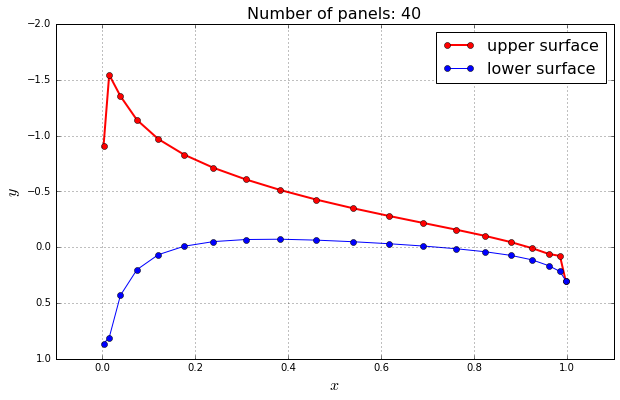

In [56]:
# plot the surface pressure coefficient 
pyplot.figure(figsize=(10,6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$y$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'], 
           [panel.cp for panel in panels if panel.loc == 'upper'], 
           label = 'upper surface',
           color = 'r', linestyle= '-', linewidth = 2, marker= 'o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'], 
            [panel.cp for panel in panels if panel.loc == 'lower'], 
            label = 'lower surface', 
            color = 'b', linestyle = '-', linewidth=1, marker= 'o', markersize = 6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0,-2.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

## Accuracy Check

For a closed body, the sume of the source strengths must be 0. If not it means the body would be adding or absorbing mass from the flow. 

sigma* l summed should be zero

In [58]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('sum of singularities strengths: {:0.6f}'.format(accuracy))

sum of singularities strengths: 0.004606


## Lift Coefficient 

The list coefficient is given by the density times circulation times freestream velocity 

The circulation is given by the sum of the gammas times length 

The lift coefficeint is just the total circulation divided by 0.5 u_inf c 
c== chord length of airfoil


In [62]:
# compute the chord and the lift coeffcient 
c = abs(max(panel.xa for panel in panels) - min(panel.xa for panel in panels))

cl = (gamma*sum(panel.length for panel in panels)
      / (0.5*freestream.u_inf*c))
print('lift coefficeint: CL = {:0.3f}'.format(cl))

lift coefficeint: CL = 0.506
